In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [11]:
def get_volt():
    # 센서에서 측정되는 전압을 가정 - 노이즈가 포함된
    
    v = np.random.normal(0, 2)
    volt_true = 14.4
    z_volt_meas = volt_true + v   # 실제 14.4 volt에 랜덤 노이즈가 포함
    
    return z_volt_meas

### 칼만 필터 (Kalman-filter)

In [18]:
def kalman_filter(z_meas, x_esti, P):
    
    # 1) prediction
    x_pred = A * x_esti
    P_pred = A * P * A + Q
    
    # 2) Kalman gain
    K = P_pred * H / (H * P_pred * H + R)
    
    # 3) Estimation
    x_esti = x_pred + K * (z_meas - H * x_pred)
    
    # 4) Error Covariance
    P = P_pred - K * H * P_pred
    
    return x_esti, P

# 칼만 필터에서 상태공간 모델링의 수식이 코드에 어떻게 적용되어 있는가? (231009)

In [19]:
# input parameters

time_end = 10   # 임의의 시간 길이 선정
dt = 0.2

In [20]:
# 상태공간 모델링 : State Space Modeling

# Initialization of system model

A = 1
H = 1
Q = 0
R = 4

# 초기값 설정
x_0 = 12
P_0 = 6 

In [21]:
time = np.arange(0, time_end, dt)  # 시작값, 종료값, 분할값 - 시간 간격 Array 생성

n_samples = len(time)  # 생성된 시간 간격 샘플의 갯수

# 더미 Array 생성
volt_meas_save = np.zeros(n_samples)
volt_esti_save = np.zeros(n_samples)

In [22]:
x_esti, P = None, None   # 0이 아닌 None을 할당하는 이유?

for i in range(n_samples):
    z_meas = get_volt()
    
    if i == 0:
        x_esti, P = x_0, P_0  # 초기값 할당
        
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)  # 칼만 필터 처리
        
    volt_meas_save[i] = z_meas   # 매시간 측정된 센서 값을 Array로 저장
    volt_esti_save[i] = x_esti   # 칼만 필터 처리된 예측값을 Array로 저장

### 이동 평균 필터(Moving average filter)

In [24]:
# time, volt_meas_save를 이용하여 이동 평균 결과를 계산해서 표현해보면

avg_val = 5
moving_average_val = np.zeros(n_samples-avg_val+1)

# rolling은 pandas dataframe에서만 사용가능
# moving_average = volt_meas_save.rolling(window=5).mean()


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w

moving_average_val = moving_average(volt_meas_save, avg_val)

print(len(moving_average_val))

46


In [25]:
print(n_samples)

moving_average_val
print(len(moving_average_val))

50
46


In [26]:
# 이동 평균을 실시하면 평균하는 그룹의 갯수 만큼 시간 영역 샘플이 줄어든다
# 초기값 5개는 원래 값 그대로 입력하면,

moving_average_val = np.insert(moving_average_val, 0, volt_meas_save[0:avg_val-1])
print(len(moving_average_val))

50


Text(0, 0.5, 'Voltage [V]')

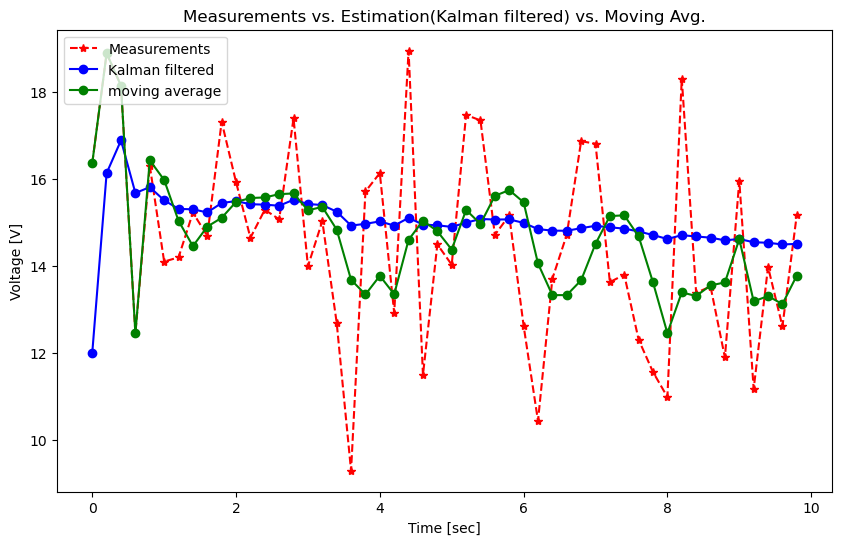

In [28]:
# 결과 출력

plt.figure(figsize=(10, 6))

plt.plot(time, volt_meas_save, 'r*--', label='Measurements')
plt.plot(time, volt_esti_save, 'bo-', label='Kalman filtered')
plt.plot(time, moving_average_val, 'go-', label='moving average')

plt.legend(loc='upper left')
plt.title('Measurements vs. Estimation(Kalman filtered) vs. Moving Avg.')
plt.xlabel('Time [sec]')
plt.ylabel('Voltage [V]')